# Batch normalization

Denote by $\mathcal{B}_j = \{x_{i,j}\}_{i=1}^{m_j}$ the set of inputs in the $j$-th mini-batch, 
where $m_j$ is the batch size. Each $x_{i,j}$ is a vector of intralayer features (channels) corresponding 
to the $i$-th sample in batch $j$.

1. Compute statistics (mean and variance) for the $j$-th batch:
  $$
  \mu_j = \frac{1}{m_j}\sum_{i=1}^{m_j} x_{i,j}, 
  \qquad
  \sigma_j^2 = \frac{1}{m_j}\sum_{i=1}^{m_j} (x_{i,j} - \mu_j)^2,
  $$
  for $j = 1, 2, \dots, N$, where $N$ is the total number of mini-batches.
  
  2. Normalize and apply learnable affine transformation with parameters (scale $\gamma$ and shift $\beta$):
  $$
  \hat{x}_{i,j} = \gamma \cdot \frac{x_{i,j} - \mu_j}{\sqrt{\sigma_j^2 + \varepsilon}} + \beta,
  $$
  so that the output of Batch Normalization for the $j$-th batch is 
  $\hat{\mathcal{B}}_j = \{\hat{x}_{i,j}\}_{i=1}^{m_j}$.

**Testing phase:** During inference we no longer rely on batch statistics. Instead, we use running estimates of the mean and variance accumulated during training. Importantly, the variance stored in the running statistics is the unbiased estimate, since the goal is to approximate the true population variance of the dataset rather than the within-batch variance.

Give a momentum parameter $m$ we compute
$$
\begin{align*}
\mu_{\text{new}} &= (1-m)\mu_{\text{old}}+ m*\mu_j,\\
\sigma^2_{\text{new}} &= (1-m)\sigma^2_{\text{old}}+ m*\frac{m_j}{m_j-1}\sigma^2_j.
\end{align*}
$$

Notice that 
$$
\frac{m_j}{m_j-1}\sigma^2_j=\frac{1}{m_j-1}\sum_{i=1}^{m_j} (x_{i,j} - \mu_j)^2
$$
is the unbiased varianace stimate.

This is cheaper that do an additional forward pass through the whole network and the whole dataset (the forwards pass of an epoach), because all the matrix multiplications and ussually irrational evaluation of the activation funcitons.

### Why $\frac{1}{n-1} \sum_{i=1}^{n} (x_{i} - \bar{x})^2$ is unbiased , for $\{x_i\}_{i=1}^n$ i.i.d?

Let's compute the mean of  
$$
\sum_{i=1}^{m} (x_{i} - \bar{x})^2,\quad \bar{x}=\frac{1}{n} \sum_{i=1}^{m} x_{i}.
$$

Since $\{x_i\}_{i=1}^n$ are i.i.d we have
$$
\begin{align*}
\mathbb{E}\bar{x}&=\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^{n} x_{i}\right]=\frac{1}{n}\sum_{i=1}^{n} \mathbb{E}[x_{i}]=\frac{n}{n}\mu= \mu,\\
\mathbb{V}\bar{x}&=\mathbb{V}\left[\frac{1}{n}\sum_{i=1}^{n} x_{i}\right]=\frac{1}{n^2}\sum_{i=1}^{n} \mathbb{V}[x_{i}]=\frac{n}{n^2}\sigma^2= \frac{\sigma^2}{n},
\end{align*}
$$
where $\mu = \mathbb{E}x_1 = ... = \mathbb{E}x_n$ and $\sigma^2 = \mathbb{V}x_1 = ... = \mathbb{V}x_n$.

Expanding the sum gives
$$
\begin{align*}
\sum_{i=1}^{n} (x_{i} - \bar{x})^2 
&= \sum_{i=1}^{n} ((x_{i} - \mu)+(\mu-\bar{x}) )^2 =\sum_{i=1}^{n}\left[ (x_{i} - \mu)^2 +2(x_{i} - \mu)(\mu -  \bar{x})+(\mu -  \bar{x})^2\right],\\
&=\sum_{i=1}^{n}(x_{i} - \mu)^2+2(\mu -  \bar{x})\sum_{i=1}^{n}(x_{i} - \mu)+n(\mu -  \bar{x})^2,\\
&=\sum_{i=1}^{n}(x_{i} - \mu)^2+2(\mu -  \bar{x})(n\bar{x} - n\mu)+n(\mu -  \bar{x})^2,\\
&=\sum_{i=1}^{n}(x_{i} - \mu)^2-n(\mu -  \bar{x})^2,\\
\end{align*}
$$


Taking expectation we optain
$$
\begin{align*}
\mathbb{E}\sum_{i=1}^{n} (x_{i} - \bar{x})^2 &=\sum_{i=1}^{n}\mathbb{E}(x_{i} - \mu)^2-n\mathbb{E}(\mu -  \bar{x})^2=\sum_{i=1}^{n}\mathbb{V}x_{i}-n\mathbb{V}\bar{x},\\
&=n\sigma^2-n\frac{\sigma^2}{n}=(n-1)\sigma^2\\
\end{align*}
$$

So 
$$
\mathbb{E}\left[\frac{1}{n-1}\sum_{i=1}^{n} (x_{i} - \bar{x})^2\right]=\sigma^2. 

$$

In [14]:
import torch
import torch.nn as nn

## Hand-Rolled 

In [15]:
class MyBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.affine = affine

        if affine:
            self.weight = nn.Parameter(torch.ones(num_features))  # γ (scale)
            self.bias = nn.Parameter(torch.zeros(num_features))   # β (shift)
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var',  torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            # Step 1: Compute batch statistics
            mean = x.mean(dim=0, keepdim=False)  # (C,)
            var = x.var(dim=0, unbiased=False, keepdim=False)  # (C,)
            
            with torch.no_grad():
                # Update running statistics using exponential moving average
                n = x.size(0)
                unbias_var = var * n / (n - 1) if n > 1 else var
                self.running_mean = self.running_mean * (1 - self.momentum) + mean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + unbias_var * self.momentum
        else:
            # Evaluation mode: use running statistics
            mean = self.running_mean
            var = self.running_var
        
        # Step 2: Normalize: (x - μ) / √(σ² + ε)
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        
        # Step 3: Apply affine transformation if enabled
        if self.affine:
            output = self.weight  * x_normalized + self.bias
        else:
            output = x_normalized
            
        return output

In [16]:
class MLPBN(nn.Module):
    def __init__(self, bn_net_cls,input_dim, hidden_dim, output_dim,pos=True):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dim:
            if pos:
                layers.append(nn.Linear(in_dim, h_dim,bias=False)) # bias learned by LinearLayer
                layers.append(bn_net_cls(h_dim)) 
            else:
                layers.append(bn_net_cls(in_dim,affine=False)) # bias learned by LinearLayer
                layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [17]:
x = torch.randn(5, 28, 28)
torch.manual_seed(1)
out_refs = []
for i in range(10):
    net = MLPBN(nn.BatchNorm1d,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out= net(x)
    out_norm=out.norm().item()
    print(f'{i} - {out_norm = }')
    out_refs.append(out)


0 - out_norm = 13.097768783569336
1 - out_norm = 9.07115364074707
2 - out_norm = 8.57376480102539
3 - out_norm = 9.37007999420166
4 - out_norm = 9.130562782287598
5 - out_norm = 8.86490535736084
6 - out_norm = 9.011763572692871
7 - out_norm = 9.001791000366211
8 - out_norm = 8.92255687713623
9 - out_norm = 8.898798942565918


In [18]:
torch.manual_seed(1)
for i in range(10):
    net = MLPBN(MyBatchNorm1d,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out = net(x)
    out_norm = out.norm().item()
    print(f'{i} - {out_norm = } - allclose: {torch.allclose(out_refs[i], out, atol=1e-5, rtol=0.0)}')

0 - out_norm = 13.097768783569336 - allclose: True
1 - out_norm = 9.07115364074707 - allclose: True
2 - out_norm = 8.57376480102539 - allclose: True
3 - out_norm = 9.370079040527344 - allclose: True
4 - out_norm = 9.130562782287598 - allclose: True
5 - out_norm = 8.864904403686523 - allclose: True
6 - out_norm = 9.011764526367188 - allclose: True
7 - out_norm = 9.001791000366211 - allclose: True
8 - out_norm = 8.922557830810547 - allclose: True
9 - out_norm = 8.898798942565918 - allclose: True


# Train 

In [19]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

### Generate data

In [20]:
f = lambda x: 1+2*x**2

N = 32
xs = (4*torch.rand(N)-2)[:,None]
ys = f(xs) + 0.5*torch.randn(N,1)
x_eval = torch.linspace(-2,2,100)

dataset = TensorDataset(xs, ys)

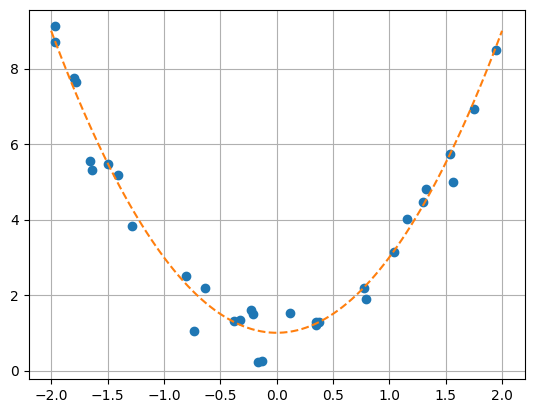

In [21]:
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o')
plt.plot(x_eval.detach().numpy(), f(x_eval).detach().numpy(), '--')
plt.grid()
plt.show()

In [27]:
lr = 0.001
momentum = 0.9
batch_size = N//4
hidden_dim = [64, 64, 64]
loss_fn = nn.MSELoss()  
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Torch

In [28]:
torch.manual_seed(1)

torchmodel = MLPBN(nn.BatchNorm1d,input_dim=1, hidden_dim=hidden_dim, output_dim=1)
opt = torch.optim.SGD(torchmodel.parameters(), lr=lr, momentum=momentum)

torchmodel.train()
torch_losses = []
for epoch in range(100):
    for x, y in data_loader:
        preds = torchmodel(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        torch_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 9.819890022277832
Epoch 10, Loss: 2.4290566444396973
Epoch 20, Loss: 9.097841262817383
Epoch 30, Loss: 1.2511638402938843
Epoch 40, Loss: 2.6905128955841064
Epoch 50, Loss: 9.077831268310547
Epoch 60, Loss: 2.862471342086792
Epoch 70, Loss: 2.2986721992492676
Epoch 80, Loss: 1.893721342086792
Epoch 90, Loss: 1.2882970571517944


### hand-rolled

In [29]:
torch.manual_seed(1)
mymodel = MLPBN(MyBatchNorm1d,input_dim=1, hidden_dim=hidden_dim, output_dim=1)
opt = torch.optim.SGD(mymodel.parameters(), lr=lr, momentum=momentum)
mymodel.train()
my_losses = []

for epoch in range(100):
    for x, y in data_loader:
        preds = mymodel(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        my_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        

Epoch 0, Loss: 9.819890022277832
Epoch 10, Loss: 2.429074287414551
Epoch 20, Loss: 9.097820281982422
Epoch 30, Loss: 1.2511720657348633
Epoch 40, Loss: 2.6905109882354736
Epoch 50, Loss: 9.078146934509277
Epoch 60, Loss: 2.862353563308716
Epoch 70, Loss: 2.298727035522461
Epoch 80, Loss: 1.8935163021087646
Epoch 90, Loss: 1.2882479429244995


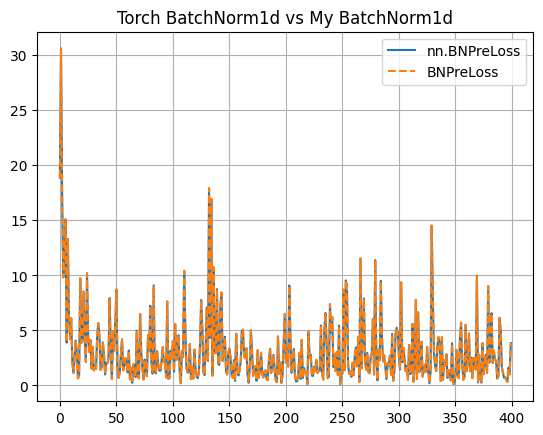

In [30]:
plt.plot(torch_losses,linestyle="-",label="nn.BNPreLoss")
plt.plot(my_losses,linestyle="--",label="BNPreLoss")
plt.title(f"Torch BatchNorm1d vs My BatchNorm1d")
plt.grid(True)
plt.legend()
plt.show()

# Evaluation

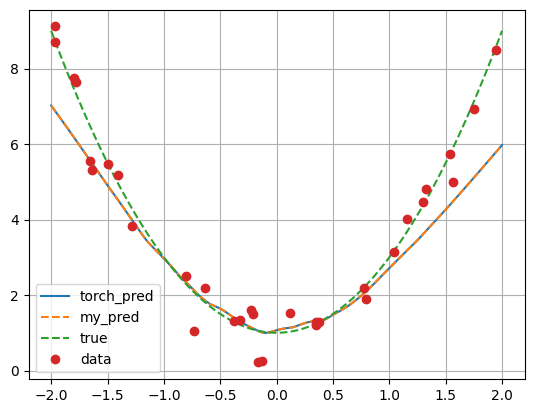

In [31]:
torchmodel.eval()
mymodel.eval()

plt.plot(x_eval,torchmodel(x_eval[:,None]).squeeze().detach().numpy(), '-',label='torch_pred')
plt.plot(x_eval,mymodel(x_eval[:,None]).squeeze().detach().numpy(), '--',label='my_pred')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o',label='data')
plt.legend()
plt.grid()
plt.show()